In [6]:
#Mounting your google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For people who attended 2020-08-06, Found out problem was order of the folders: os.listdir() function does not have any sorting function itself, so can read label_4 folder first than label_0, so must have sorting function or careful with indexing

Train: https://drive.google.com/file/d/1g6NYnHvbibYjLAeVGdY2OB0gfZkEpuKz/view?usp=sharing

Test: https://drive.google.com/file/d/1itrsW_uq9PJBdV4ierbOhlC5ZYVvNI5q/view?usp=sharing


In [24]:
import zipfile


zip_ref = zipfile.ZipFile(f"/content/drive/Shared drives/Cognitive_Systems_AI/Python-Hackathon/Collab/resized_img", 'r') #File path for each label Your own google drive
zip_ref.extractall(f"/content/sample_data/train") #Save path
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/Shared drives/Cognitive_Systems_AI/Python-Hackathon/Collab/affectnet_test_data.zip", 'r') #File path for test set
zip_ref.extractall("/content/sample_data/test") #Save path
zip_ref.close()



Extracting:  label0.zip
Extracting:  label1.zip
Extracting:  label2.zip
Extracting:  label3.zip
Extracting:  label4.zip
Extracting:  label5.zip
Extracting:  label6.zip


In [25]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.preprocessing import LabelEncoder
import os

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

In [30]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [56]:
class my_data(Dataset):
    def __init__(self, data_root,transform=None,train=True):
        self.LABEL=['Neutral','Happy','Sad','Surprise','Fear','Disgust','Anger']
        self.samples = []
        self.label_num=[]
        self.race_codec = LabelEncoder()
        self.train=train
        if self.train:
            for label in sorted(os.listdir(data_root)):   ##IMPORTANT "SORTED" in front
                label_folder = os.path.join(data_root, label)
                self.label_num.append(len(os.listdir(label_folder)))
                for img_name in sorted(os.listdir(label_folder)):
                    self.samples.append( os.path.join(label_folder, img_name)) ##SAVING FILEs PATH FOR DATASET
        else:
             for img_name in sorted(os.listdir(data_root)):
                    self.samples.append( os.path.join(data_root, img_name))  ##SAVING FILEs PATH FOR DATASET
                
        if self.train:
            for i in range(len(self.label_num)):
                print(f'{self.LABEL[i]}: {self.label_num[i]}')  ##Printing LABEL's distribution
                
        if transform == None:  
            self.transform=transforms.Compose([transforms.Resize((128,128)),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
            
        else:
            self.transform =transform  #CUSTOMIZABLE TRANSFORM
            
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        tmp_num = self.samples[idx].find('label_')+6

        if self.train:
            label_index=self.samples[idx][tmp_num:tmp_num+1]
        else:
            label_index=0
        
        img= Image.open(self.samples[idx])
        
        img=self.transform(img)
        return img,torch.tensor(int(label_index)),self.samples[idx]

In [57]:
train_data=my_data("/content/sample_data/train_",train=True)
test_data=my_data("/content/sample_data/test",train=False)  #Must have same output with the one without GoogleColab (using own computer)

Neutral: 10862
Happy: 16817
Sad: 5921
Surprise: 4784
Fear: 4013
Disgust: 3755
Anger: 5863


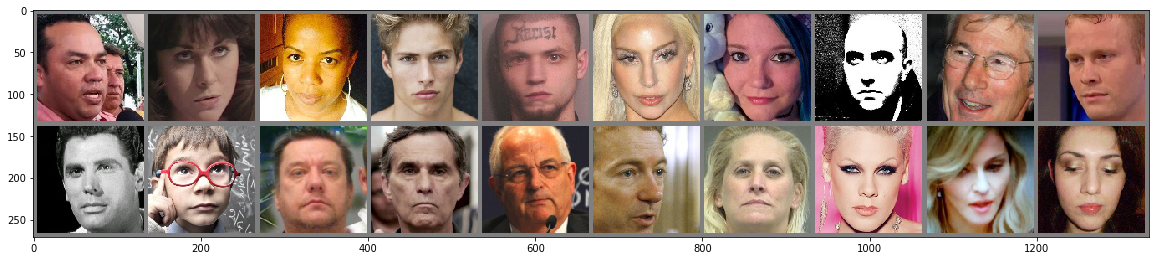

In [58]:
def show(img):
    npimg = img.numpy()
    
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1,2,0))*0.5+0.5, interpolation='nearest')
num_sample=5

test_index=random.sample(range(0,3500), 20)
imglist=[]
for i in test_index:
    imglist.append(train_data[i][0])
show(make_grid(imglist,nrow=10 ,padding=5))

In [59]:
train_len = int(0.7*len(train_data))
valid_len = len(train_data) - train_len
train_set,val_set=torch.utils.data.random_split(train_data,[train_len,valid_len])   #Spliting Dataset

In [60]:
train_dataloader = torch.utils.data.DataLoader(
        train_set, batch_size=64, shuffle=True)


val_dataloader = torch.utils.data.DataLoader(
        val_set, batch_size=64, shuffle=False)

In [61]:
class CNN(nn.Module):  #Simple CNN Network
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3,16,5), 
            nn.ReLU(),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,5),  
            nn.ReLU(),
            nn.Conv2d(64,16,5), 
            nn.MaxPool2d(2,2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(10816, 100),
            nn.ReLU(),
            nn.Linear(100,7)
        )       

    def forward(self,x):
        out = self.layer(x)
        out = out.view(x.size(0),-1)
        out = self.fc_layer(out)

        return out
    
model = CNN()

In [62]:
total_params = sum(p.numel() for p in model.parameters())
print("Num of Total Parameter : ",total_params)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Num of Trainable Parameter :",trainable_params)

Num of Total Parameter :  1173335
Num of Trainable Parameter : 1173335


In [64]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
loss = nn.CrossEntropyLoss()
model=model.to(DEVICE)
print(DEVICE) #Check Cuda

cuda:0


In [67]:
def compute_accuracy(model, data_loader,loss):
    model.eval()
    curr_loss,correct_pred, num_examples = 0,0, 0
    with torch.no_grad():
        for i, (features, targets,_) in enumerate(data_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            logits = model(features)
            cost = loss(logits, targets)
            curr_loss += cost.item()
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        curr_loss = curr_loss / i
    return correct_pred.float()/num_examples * 100,curr_loss

In [68]:
import time
train_loss=[]
valid_loss=[]
valid_accuracy=[]
num_epochs=20
start_time = time.time()

for epoch in range(num_epochs):

    model.train()
    for batch_idx, (features, targets,_) in enumerate(train_dataloader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits = model(features)
        cost = loss(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataloader), cost.item()))
            train_loss.append(cost.item())

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        accuracy,cost=compute_accuracy(model, val_dataloader,loss)
        valid_loss.append(cost)
        valid_accuracy.append(accuracy)
        print('Epoch: %03d/%03d | Accuracy: %.3f%% | Loss: %.3f' % (
              epoch+1, num_epochs, 
              accuracy,
              cost))

    torch.save(model,"model.h")

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/020 | Batch 0000/0569 | Cost: 1.0803
Epoch: 001/020 | Batch 0100/0569 | Cost: 1.1899
Epoch: 001/020 | Batch 0200/0569 | Cost: 1.0508
Epoch: 001/020 | Batch 0300/0569 | Cost: 1.4525
Epoch: 001/020 | Batch 0400/0569 | Cost: 1.1266
Epoch: 001/020 | Batch 0500/0569 | Cost: 1.1176
Epoch: 001/020 | Accuracy: 55.296% | Loss: 1.238
Time elapsed: 1.69 min
Epoch: 002/020 | Batch 0000/0569 | Cost: 0.9496
Epoch: 002/020 | Batch 0100/0569 | Cost: 0.9794


KeyboardInterrupt: ignored

In [ ]:
#DAEHYUN's tip
#RUN REALLY LONG CODE TO PREVENT RUNTIME STOPPING
such as
import time
#Number to REALLY LARGE VALUE
for i in range(10000):
    time.sleep(120)
    print(i)
